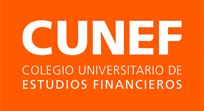

# Máster en Data Science - Machine Learning

# Predicción de fraude mediante el uso de modelos de Machine Learning
##### <font color='dodgerblue' face='Montserrat'>Autor: Rodrigo Fernandez Campos</font>
## DataSet: Bank Account Fraud Dataset Suite (NeurIPS 2022)

# <font size=25><b>Comparación y seleccion de Modelos</b></font>

En este notebook se realizarán unos últimos tratamientos a los datos, como lo son el Oversampling y Undersampling, además del escalado y recorte de variables en base a lo decidido en el notebook anterior (03) y luego se procederá a la comparación y selección del modelo óptimo para resolver nuestro problema. Se aplicarán muchos modelos de Machine Learning para problemas de Clasificación en su versión por defecto, luego se seleccionará la configuración de datos con la que funcione mejor dicho modelo y finalmente se buscarán los hiperparámetros que mejores resultados obtengan. Para todos estos procesos de comparación y medidas se utilizará un set de Validación, que surgirá de volver a dividir en 70-30 al set de entrenamiento.

In [121]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored, cprint
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import TargetEncoder
import sys
import importlib
from matplotlib import rc

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import lightgbm
from lightgbm.sklearn import LGBMClassifier
from sklearn.svm import SVC
from sklearn.metrics import fbeta_score, make_scorer

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
import statsmodels.api as sm

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import NearMiss, TomekLinks

from sklearn.metrics import balanced_accuracy_score, roc_auc_score,\
                            accuracy_score,average_precision_score, precision_recall_curve, roc_curve,\
                            auc, recall_score, precision_score, confusion_matrix, f1_score
import pickle
from joblib import dump, load

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

## Funciones

In [122]:
sys.path.append('../src/')
import functions_rfc as fr
sys.path.remove('../src/')

### Constantes:
seed=10

In [127]:
sys.path.append('../src/')
importlib.reload(fr)
sys.path.remove('../src/')

***
# Importo y preparo los datasets

## Importo datasets procesados con anterioridad

In [364]:
df_fraud_train = pd.read_csv('../data/interim/df_fraud_train.csv')

df_fraud_train

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,month,fraud_bool
0,0.9,0.237329,-1,80,40,0.013515,-1.041418,AC,1589,5840.486860,7660.279574,6353.443336,0,12,CA,100,1,BA,0,1,-1,0,2000.0,0,INTERNET,3.436651,other,1,1,0,0
1,0.9,0.176307,-1,54,40,0.019225,-0.835103,AC,882,3442.067872,4575.631214,5571.455566,1,7,CF,106,0,BC,0,1,-1,0,200.0,0,INTERNET,6.356665,linux,0,1,2,0
2,0.1,0.265706,157,156,40,0.011588,37.078740,AA,1298,1196.731284,4008.487554,4212.552556,728,2,CA,137,0,BE,1,1,11,1,500.0,0,INTERNET,17.815440,windows,1,1,6,0
3,0.9,0.089557,35,5,20,0.025159,37.116540,AA,1337,9563.602945,2838.222720,3508.471021,429,11,CA,242,1,BC,0,1,21,0,200.0,0,INTERNET,4.443607,other,1,1,2,0
4,0.7,0.882855,-1,117,40,0.003562,-0.332094,AC,1333,1954.199605,2811.816273,4267.415243,1,2,CA,225,1,BA,1,1,-1,0,1000.0,0,INTERNET,3.170467,windows,1,1,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699995,0.7,0.999167,-1,43,30,0.023268,-1.259374,AB,818,7460.133835,5020.933076,5578.160984,35,14,CA,123,1,BC,1,1,15,0,1500.0,0,INTERNET,5.411712,linux,1,1,1,0
699996,0.8,0.064547,-1,135,50,0.009240,103.081065,AA,839,3732.754501,3857.194697,5300.048190,470,4,CA,219,1,BA,1,1,28,0,1500.0,0,INTERNET,1.797181,other,1,1,1,0
699997,0.6,0.413827,49,9,30,0.009545,-1.413444,AD,3525,8000.519630,6734.795342,6292.454641,51,19,CB,220,1,BC,0,1,1,0,200.0,0,INTERNET,4.217826,macintosh,1,1,0,0
699998,0.9,0.341045,-1,109,30,0.030424,-1.228380,AB,809,6141.098226,4824.862636,4180.026219,9,8,CA,218,1,BA,0,1,1,1,1500.0,0,INTERNET,0.915473,macintosh,0,1,5,0


In [353]:
df_fraud_train_cut = fr.feature_selection(fr.preprocessing_mix(df_fraud_train).fit_transform(df_fraud_train, df_fraud_train.fraud_bool))
df_fraud_train_cut.shape

(700000, 30)

In [354]:
df_fraud_train = fr.preprocessing_mix(df_fraud_train).fit_transform(df_fraud_train, df_fraud_train.fraud_bool)

Separo en X e y:

In [355]:
X_train_0 = df_fraud_train_cut.drop('fraud_bool', axis=1)
y_train_0 = df_fraud_train_cut['fraud_bool']

## Separación en train y validation estratificado

In [356]:
X_train_1, X_val, y_train_1, y_val = train_test_split(df_fraud_train_cut.drop('fraud_bool',axis=1)
                                                  ,df_fraud_train_cut['fraud_bool']
                                                  ,stratify=df_fraud_train_cut['fraud_bool']
                                                  ,test_size=0.3
                                                  ,random_state=seed)

X_train_complete, X_val_complete, y_train_complete, y_val_complete = train_test_split(df_fraud_train.drop('fraud_bool',axis=1)
                                                                                      ,df_fraud_train['fraud_bool']
                                                                                      ,stratify=df_fraud_train['fraud_bool']
                                                                                      ,test_size=0.3
                                                                                      ,random_state=seed)

In [137]:
X_train_1.shape, X_val.shape, X_train_complete.shape, X_val_complete.shape

((490000, 29), (210000, 29), (490000, 30), (210000, 30))

In [138]:
X_train_1.head()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,bank_months_count,proposed_credit_limit,session_length_in_minutes,device_distinct_emails_8w,month,employment_status,housing_status,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11,payment_type,email_is_free,phone_home_valid,has_other_cards,keep_alive_session
599230,0.817562,-0.341912,0.143019,-0.967741,-0.305959,1.447015,2.024380,-1.181284,0.197357,-0.401099,-0.101053,0.072083,0.343029,-0.647840,-0.321803,-0.101291,0.321790,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.005190,1,0,0,1
499762,-0.215980,0.122728,-0.401845,0.208555,0.525351,-0.186140,-0.489139,-0.465474,-0.502602,-0.398925,-0.895989,0.804141,-0.812265,0.992135,-0.423232,-0.101291,1.226563,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.011236,1,1,0,0
345290,0.817562,0.094871,-0.401845,1.712858,0.525351,-0.185020,-0.514848,-0.441614,-1.064146,-0.401099,-1.293456,1.234764,0.343029,-0.647840,0.021948,-0.101291,1.226563,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.005211,0,1,0,1
571303,-0.560495,0.883171,-0.401845,1.712858,1.356662,-0.188056,-0.491821,1.545753,1.693476,-0.368493,-0.299787,1.292180,-0.812265,2.017120,0.948243,-0.101291,-1.487757,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.011105,0,0,0,1
379531,0.817562,0.147328,-0.401845,-0.368282,-1.137270,-0.189134,-0.492481,-0.058854,0.474007,-0.398925,2.681222,-1.004473,-0.977307,-0.647840,-0.725261,-0.101291,-1.035370,4.0,2.0,0.0,0.0,1.0,0.0,0.0,0.016497,0,0,0,1


### Realizo el escalado para utilizar al aplicar el modelo de Regresión Logística

In [313]:
scaler = StandardScaler()
model_scaled = scaler.fit(X_train_1)
X_train_scaled = pd.DataFrame(scaler.transform(X_train_1), columns=X_train_1.columns, index=X_train_1.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)

X_train_scaled.head() # muestro uno de ejemplo

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,bank_months_count,proposed_credit_limit,session_length_in_minutes,device_distinct_emails_8w,month,employment_status,housing_status,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11,payment_type,email_is_free,phone_home_valid,has_other_cards,keep_alive_session
599230,0.818054,-0.343280,0.143115,-0.967765,-0.305901,1.447000,2.020976,-1.180281,0.196153,-0.401179,-0.101360,0.071745,0.343223,-0.648162,-0.322339,-0.102353,0.322146,-0.472918,0.179838,1.415899,-0.238188,-0.722341,-0.597981,-0.085391,-1.426951,0.941083,-0.846181,-0.535643,0.855731
499762,-0.215517,0.121335,-0.401420,0.209070,0.525633,-0.186334,-0.489476,-0.465409,-0.503448,-0.399003,-0.896458,0.803466,-0.812526,0.991825,-0.423522,-0.102353,1.226557,3.441977,-0.608383,1.415899,-0.238188,-0.722341,-0.597981,-0.085391,0.083079,0.941083,1.181780,-0.535643,-1.168592
345290,0.818054,0.093479,-0.401420,1.714061,0.525633,-0.185214,-0.515154,-0.441580,-1.064705,-0.401179,-1.294007,1.233890,0.343223,-0.648162,0.020578,-0.102353,1.226557,-0.472918,-0.608383,-0.706265,-0.238188,1.384387,-0.597981,-0.085391,-1.415680,-1.062605,1.181780,-0.535643,0.855731
571303,-0.560041,0.881738,-0.401420,1.714061,1.357168,-0.188250,-0.492155,1.543181,1.691507,-0.368540,-0.300134,1.291279,-0.812526,2.016816,0.944626,-0.102353,-1.486677,-0.472918,-0.608383,-0.706265,-0.238188,-0.722341,1.672294,-0.085391,-0.033511,-1.062605,-0.846181,-0.535643,0.855731
379531,0.818054,0.145933,-0.401420,-0.368032,-1.137436,-0.189328,-0.492814,-0.059322,0.472662,-0.399003,2.681483,-1.004315,-0.977633,-0.648162,-0.724818,-0.102353,-1.034471,2.658998,0.179838,-0.706265,-0.238188,1.384387,-0.597981,-0.085391,1.350299,-1.062605,-0.846181,-0.535643,0.855731


***
# Unsersampling y Oversampling

Investigando en internet me he topado con una técnica que me parece interesante, que es una combinación proporcional de undersampling y oversampling. He decidido probarlo mediante la aplicación de un Pipeline en donde se aplican secuencialmente las técnicas.

Me parece una aplicación interesante para casos como el de este dataset en donde los datos están extremadamente desbalanceados, al punto de que un undersampling aplicado directamente eliminaría una cantidad demasiado alta de información, mientras que un oversampling podría generar un sesgo por la cantidad enorme de datos sintéticos a generar. Es por eso que un acercamiento entre ambos parece una solución curiosa desde el punto de vista de la prueba, aunque he de decir que también tengo cierto escepticismo con respecto a la técnica, debido a que puede significar tocar demasiado el dataset. En un proyecto real sería más conservador probablemente y optaría por una de las dos metodologías puras.

Existen dentro de Imbalanced-Learning de SKL dos funciones con una combinación interna de oversampling y undersampling, pero al probarlas no parecen estar optimizadas y el costo computacional que me requieren es demasiado alto, por eso generaré y aplicaré mi propio Pipeline manualmente.

Entonces, para lidiar con el desbalanceo terminaré aplicando:

1. Split estatificado (SE) --> (realizado en Notebook 02) --> Todos los demás pasos tienen este por detrás.
2. RandomUnderSampling
3. SMOTE OverSampling
4. Pipeline con sampling mix --> (SMOTE OverSampling + Random UnderSampling)


In [140]:
# El tamaño y distribución actual del DataSet de train son los siguientes:
X_train_1.shape,y_train_1.value_counts(),y_train_1.value_counts(normalize=True)

((490000, 29),
 fraud_bool
 0    484596
 1      5404
 Name: count, dtype: int64,
 fraud_bool
 0    0.988971
 1    0.011029
 Name: proportion, dtype: float64)

#### 1. Random Undersampling

Para elegir la estrategia de muestreo óptima y el tipo de undersampling (Random por sobre TomekLink o NearMiss) estuve realizando algunas pruebas que pueden verificarse en el notebook de la carpeta Experiments. Básicamente he elegido el balanceo que mejores resultados daba manteniendo equilibrio entre f1 y f2.

In [357]:
undersamp = RandomUnderSampler(sampling_strategy=0.08, random_state=seed)
X_train_under, y_train_under = undersamp.fit_resample(X_train_1, y_train_1)

In [142]:
X_train_under.shape,y_train_under.value_counts(),y_train_under.value_counts(normalize=True)

((72954, 29),
 fraud_bool
 0    67550
 1     5404
 Name: count, dtype: int64,
 fraud_bool
 0    0.925926
 1    0.074074
 Name: proportion, dtype: float64)

In [143]:
1 - X_train_under.shape[0] / X_train_1.shape[0]

0.8511142857142857

Logramos el cometido, el dataset está balanceado, pero solo nos quedamos con casi 73k datos, es decir que perdimos el 85% de nuestro dataset, 
dato que es al menos recalcable. Habrá que ver como funcionan los modelos con una reducción tan grande del dataset.

#### 2. SMOTE OverSampling

In [358]:
oversamp = SMOTE(sampling_strategy=0.25, random_state=seed)
X_train_over, y_train_over = oversamp.fit_resample(X_train_1, y_train_1)

In [56]:
X_train_over.shape,y_train_over.value_counts(),y_train_over.value_counts(normalize=True)

((605745, 25),
 fraud_bool
 0    484596
 1    121149
 Name: count, dtype: int64,
 fraud_bool
 0    0.8
 1    0.2
 Name: proportion, dtype: float64)

In [57]:
y_train_over.value_counts()[1] - y_train_1.value_counts()[1]

115745

In [58]:
(y_train_over.value_counts()[1] - y_train_1.value_counts()[1]) / y_train_1.size

0.2362142857142857

Con este método generamos 115k nuevos registros, es decir que agrandamos nuestro dataset de manera sintética casi un 24%, lo cual parece bastante,
pero habrá que comprobarlo con los resultados del modelo.

#### 3. Mix con Pipeline (SMOTE OverSampling + UnderSampling):

In [359]:
over = SMOTE(sampling_strategy=0.2, random_state=seed)
under = RandomUnderSampler(sampling_strategy=0.25, random_state=seed) # Voy a buscar una proporción de aprox 60%-40%
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_train_mix, y_train_mix = pipeline.fit_resample(X_train_1, y_train_1)

In [60]:
X_train_mix.shape,y_train_mix.value_counts(),y_train_mix.value_counts(normalize=True)

((484595, 25),
 fraud_bool
 0    387676
 1     96919
 Name: count, dtype: int64,
 fraud_bool
 0    0.8
 1    0.2
 Name: proportion, dtype: float64)

Vemos que de esta manera reducimos a poco más de la mitad los datos originales de train y la cantidad de datos a generar sintéticamente

El tamaño del dataset no es minúsculo ni se expandió de manera tan abrupta, sino que casi que se mantuvo en su tamaño gracias al mix aplicado.

Por supuesto que nunca vamos a llegar a una solución perfecta, a priori parece razonale, aunque sin haberla medido. La hora de la verdad llegará cuando comencemos a probar los modelos, a pesar de que da un poco de desconfianza modificar tanto los datos.

In [22]:
X_train_mix.head()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,bank_months_count,proposed_credit_limit,session_length_in_minutes,device_distinct_emails_8w,month,payment_type,employment_status,housing_status,device_os,email_is_free,phone_home_valid,has_other_cards,keep_alive_session
339345,1.162077,-1.213468,-0.401845,-0.153382,1.356662,-0.189568,-0.437213,-0.453544,-0.914718,-0.396752,-0.498521,1.335242,-0.977307,-0.647840,-0.515288,-0.101291,1.226563,2.0,3.0,0.0,1.0,1,1,0,0
453683,-1.594037,-0.599501,-0.129413,-0.899878,-1.137270,-0.189999,-0.481041,1.763478,0.080049,-0.401099,0.097681,2.268258,-0.977307,-0.647840,-0.418075,-0.101291,0.321790,2.0,0.0,2.0,3.0,1,1,0,0
198425,0.473048,1.273549,-0.401845,-0.707599,-1.137270,-0.188339,-0.461779,-0.692147,0.235829,3.518122,0.693883,0.000313,0.343029,0.992135,-0.257553,-0.101291,-0.130597,3.0,0.0,4.0,2.0,1,0,0,0
165400,0.817562,0.710729,-0.401845,0.875877,-1.137270,-0.188683,-0.461813,2.995268,1.306204,3.396394,0.097681,-0.186290,0.673113,-0.647840,-0.852997,-0.101291,-1.487757,1.0,0.0,4.0,2.0,1,0,0,1
72103,-0.560495,-1.618053,0.279235,-0.877257,-1.137270,-0.186353,-0.487278,-0.115523,-0.037147,-0.377188,0.097681,0.918974,1.663364,-0.647840,2.197689,-0.101291,0.321790,1.0,0.0,2.0,1.0,1,0,0,1


In [360]:
# restauro el index:
X_train_mix = X_train_mix.reset_index(drop=True)
y_train_mix = y_train_mix.reset_index(drop=True)

## Añadido de PCA como prueba para mejora del modelo

Además de los tratamientos realizados, generaré otro dataframe igual a X_train pero con las dos variables de PCA con el fin de, como se comentó en el notebook anterior, probar si mejoran el modelo o si por el contrario solo agregan ruido.

Para ello importaré el modelo ya entrenado en el notebook anterior. Deberé aplicarlo primero sobre el Dataset con todas las variables y luego recortarlo (al haberse usado la misma semilla son exactamente iguales el completo y el recortado con la única diferencia de que uno tiene más variables que el otro):

In [147]:
pca = load('../models/pca_2components.joblib')

In [289]:
X_train_pca = X_train_1.copy()
X_val_pca = X_val.copy()
X_train_pca['PCA1'], X_train_pca['PCA2'] = pca.transform(X_train_complete)[:,0], pca.transform(X_train_complete)[:,1]
X_val_pca['PCA1'], X_val_pca['PCA2'] = pca.transform(X_val_complete)[:,0], pca.transform(X_val_complete)[:,1]
X_train_pca.head()

ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.


## Resumen del tratamiento previo al modelado

Una vez que he importado todos los datasets, generado sets de validación para comparar los modelos y agregar procesos de oversampling y undersampling, voy a proceder a la parte del modelado.

El proceso de comentará a continuación en el siguiente apartado, pero antes de continuar voy a listar los datasets generados con los que voy a trabajar:

1. Set sin recortes
2. Set procesado con variables seleccionadas (5 menos que el original importado gracias al Feature Selection)
3. Set escalado
4. Set con variables PCA
5. Set con Undersampling
6. Set con Oversampling
7. Set con mix Over y Under sampling.

Aunque parecen muchos, son bastante similares entre si y la idea es realizar una validación numérica de con cual de ellos se obtendrían a priori mejores resultados, para no basarnos simplemente en intuición a la hora de buscar la optimización del uso de los datos disponibles en el modelo que elijamos.

***

# Modelado

En este apartado de trataran los distintos modelos elegidos con los datasets disponibles. La idea es llegar al final del notebook con la elección tanto del modelo a utilizar, del dataset que mejor se adapte al mismo y de los hiperparámetros que optimizen los resultados buscados. Para lograrlo realizaré 3 pasos:

1. Comparativa de modelos: Mediante un pipeline se probarán todos los modelos sin ajustar hiperparámetros, solo con sus valores por defecto, para ver cual es el que mejores resultados base proporciona.

2. Comparativa de datasets: Con el modelo elegido se procederá a medir cual es el set de datos que mejores métricas obtiene.

3. Búsqueda de hiperparámetros: Finalmente se realizará una búsqueda de los hiperparámetros que optimizen al modelo elegido en el dataset elegido mediante una Validación Cruzada.

## Modelo Base:

En primer lugar voy a realizar un modelo sin machine learning, en donde simplemente se asignará el valor de la clase mayoritaria a todos los resultados. En este caso, consideraremos que ninguna aplicación será fraudulenta. Esto es lo que haríamos si no pudiesemos aplicar ningún modelo.

He generado una función propia que me permite determinar la clase mayoritaria y en base a eso generar las predicciones de un modelo base para mi análisis:

In [149]:
y_pred_base = fr.y_pred_base_model(y_train_1,X_val)

In [150]:
y_pred_base, y_pred_base.shape

(array([0, 0, 0, ..., 0, 0, 0], dtype=int64), (210000,))

Aplico una función propia generada para resaltar las métricas que considero importantes a la hora de evaluar los modelos:

In [151]:
fr.metrics_summ(y_val, y_pred_base)


Accuracy: 0.98897
Balanced Accuracy: 0.50000
F2 score: 0.00000
F1 score: 0.00000
Precision: 0.00000
Recall: 0.00000

Confusion Matrix:
[[207684      0]
 [  2316      0]]


Aplico una función propia creada justamente para graficar la matriz de confusión con los valores brutos y también en su versión normalizada:

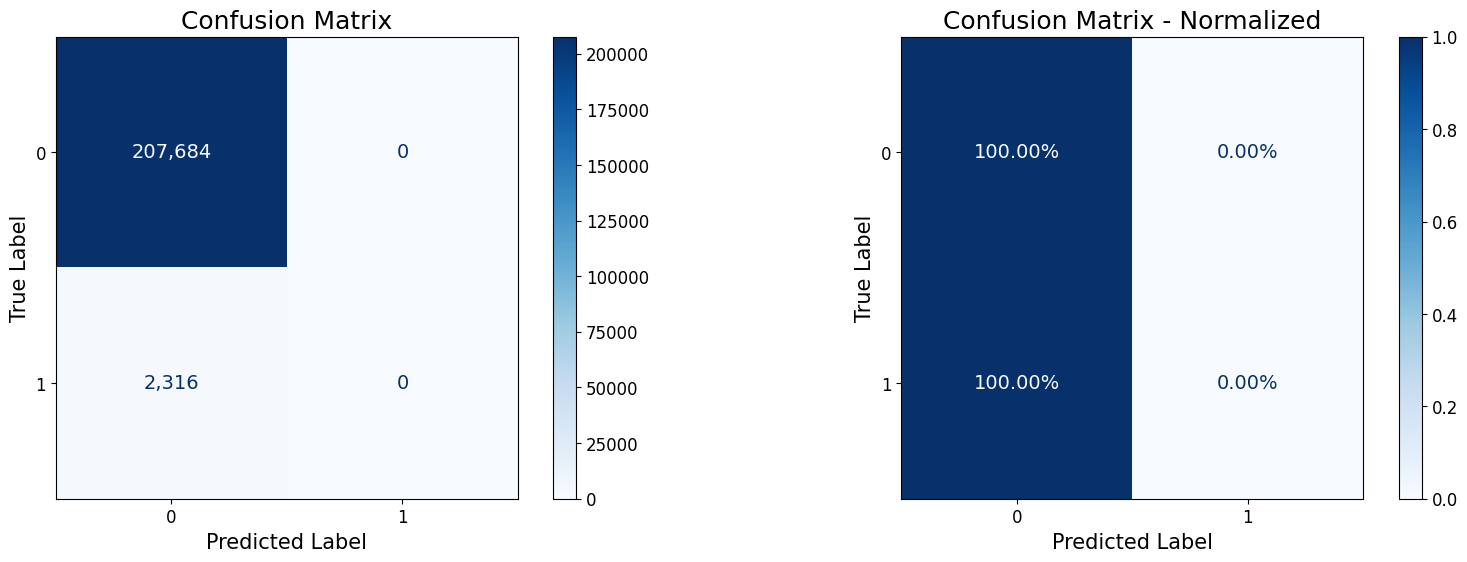

In [26]:
fr.plot_cmatrix(y_val, y_pred_base)

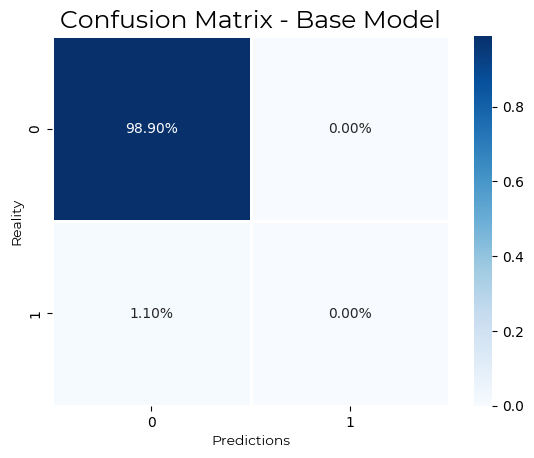

In [29]:
# Además, también voy a graficar una confusion matrix con los porcentajes sobre el total:
cf_matrix = confusion_matrix(y_val,y_pred_base)
cf_matrix_perc = cf_matrix/np.sum(cf_matrix)

heatmap = sns.heatmap(cf_matrix_perc, annot=True, fmt='.2%', cmap='Blues', linewidth=2)
plt.xlabel('Predictions', fontdict={'fontname':'Montserrat'})
plt.ylabel('Reality', fontdict={'fontname':'Montserrat'})
plt.title('Confusion Matrix - Base Model', fontdict={'fontname':'Montserrat', 'fontsize':18})
plt.show()

Una vez contamos con el modelo base, procedemos a realizar la comparación de modelos con Machine Learning

***
# 1. Comparación de Modelos

A continuación ejecutaré un pipeline con algunos de los modelos de clasificación 



## Logistic Regression

Antes de realizar el pipeline, voy a ejecutar la regresión logística, que a diferencia de los demás, necesita utilizar el dataset escalado.

Este es un modelo de tipo lineal (GLM) que permite obtener resultados adecuados para problemas de clasificación binara, por lo que se adapta muy bien a nuestro objetivo a priori.

In [152]:
%%time
lr = LogisticRegression(C=1)
lr.fit(X_train_scaled, y_train_1)

y_pred_lr = lr.predict(X_val_scaled)

fr.metrics_summ(y_val, y_pred_lr)


Accuracy: 0.98899
Balanced Accuracy: 0.50278
F2 score: 0.00700
F1 score: 0.01112
Precision: 0.56522
Recall: 0.00561

Confusion Matrix:
[[207674     10]
 [  2303     13]]
CPU times: total: 5.42 s
Wall time: 2.89 s


Los resultados han sido un poco decepcionantes, debido a que es levemente superior al modelo base. Son muy pocos los registros que consigue determinar como
fraude.

## Support Vector Machine

Este modelo es conocido por ser especialmente demandante computacionalmente hablando, por lo que en este caso procederé a probarlo con el dataset más pequeño posible. Debido a su alto coste computacional y a que no tiene un rendimiento tan bueno a priori como otros modelos que probaremos a continuación, considero adecuado probarlo con un dataset menor, ya que no tengo altas expectativas en cuanto a su desempeño.

En vez de reducir los datos a un porcentaje, voy a aprovechar que ya poseo un dataset más pequeño, que en este caso es el que ha pasado por el proceso de Undersampling.

###### *Nota: Es posible que este modelo obtenga mejores métricas debido a que está trabajando con un dataset balanceado. De igual manera, será comparado vs el mejor modelo elegido comprobando sus mejores métricas en varios DF de prueba. Por lo que, en caso de obtener buenos resultados, deberán compararse vs el otro modelo elegido en el mismo dataset con undersampling.*

In [57]:
%%time
svc = SVC(kernel="rbf", degree=3) # utilizo los valores por defecto. Solo los dejo aclarados para mejor entendimiento.
svc.fit(X_train_under, y_train_under)

# este modelo fue corrido antes de crear la función fr.metrics_summ(), por lo que el código bruto fue inicial más ineficiente, pero no me vale la pena volver a correr
# dicho modelo que demora bastante y requiere mucha potencia computacional para obtener resultados pobres, por eso mantengo el código inicial sin usar mi función de medición

accuracy = accuracy_score(y_val,svc.predict(X_val))
balanced_acc = balanced_accuracy_score(y_val,svc.predict(X_val))
f1 = f1_score(y_val,svc.predict(X_val)) # (y_true, y_pred)
c_matrix = confusion_matrix(y_val,svc.predict(X_val))
precision = precision_score(y_val,svc.predict(X_val))
recall = recall_score(y_val,svc.predict(X_val))
print(f"""
accuracy = {accuracy}
balanced accuracy = {balanced_acc}
precision = {precision}
recall = {recall}
f1_score = {f1}
confusion matrix:
{c_matrix}
""")


accuracy = 0.9889714285714286
balanced accuracy = 0.5
precision = 0.0
recall = 0.0
f1_score = 0.0
confusion matrix:
[[207684      0]
 [  2316      0]]

CPU times: total: 33min 17s
Wall time: 38min 19s


La aplicación en este caso fue un fracaso. Además de la enorme cantidad de tiempo que demoró en comparación con otros modelos, la predicción simplemente
actuó como si se tratara del modelo base, por lo que el SVC queda descartado de los posibles modelos a elegir.

## Pipeline con los demás modelos

Ahora si procedo a probar el resto de los modelos en un pipeline:

* DummyClassifier: Incluyo lo que sería un modelo base de SKLearn
* GaussianNB: El clasificador de Naive Bayes, basado en las teorías de probabilidad Gaussianas, un tipo de modelo bastante eficiente en aprendizaje supervisado.
* Decision Tree Classifier: Árbol de decisión simple
* Random Forest Classifier: Emsamblaje de muchos clasificadores de árbol de decisión, en representación de los modelos de Bagging
* XGBoost Classifier: Representante de los modelos de boosting, uno de los más efectivos actualmente en ML.
* LightGBM Classifier: También representante de los modelos de boosting, de mis favoritos actualmente debido a su eficiencia y sobre todo a su gran optimización en cuanto a los tiempos de procesamiento. 

In [65]:
%%time

classifiers = [
    DummyClassifier() # incluyo lo que sería un modelo base de SKLearn
    ,GaussianNB() # Clasificador de NaiveBayes
    ,DecisionTreeClassifier() # Árbol de decisión simple
    ,RandomForestClassifier() # Random Forest en representación de modelos de Bagging
    ,XGBClassifier() # Modelo boosting
    ,LGBMClassifier() # Modelo boosting
    ]

for classifier in classifiers:
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(X_train_1, y_train_1)   
    y_pred_pipe = pipe.predict(X_val)
    print(f'\033[1m{classifier}\033[0m')
    fr.metrics_summ(y_val, y_pred_pipe)
    print("____________________________________________________________________________________________")


DummyClassifier()

Accuracy: 0.98897
Balanced Accuracy: 0.50000
F2 score: 0.00000
F1 score: 0.00000
Precision: 0.00000
Recall: 0.00000

Confusion Matrix:
[[207684      0]
 [  2316      0]]
____________________________________________________________________________________________
GaussianNB()

Accuracy: 0.93935
Balanced Accuracy: 0.67089
F2 score: 0.21329
F1 score: 0.12600
Precision: 0.07490
Recall: 0.39637

Confusion Matrix:
[[196346  11338]
 [  1398    918]]
____________________________________________________________________________________________
DecisionTreeClassifier()

Accuracy: 0.97686
Balanced Accuracy: 0.54084
F2 score: 0.08982
F1 score: 0.08303
Precision: 0.07375
Recall: 0.09499

Confusion Matrix:
[[204921   2763]
 [  2096    220]]
____________________________________________________________________________________________
RandomForestClassifier()

Accuracy: 0.98899
Balanced Accuracy: 0.50150
F2 score: 0.00377
F1 score: 0.00602
Precision: 0.63636
Recall: 0.00302

Confusion

## Modelo a seleccionar

Una vez ejecutados los modelos de clasificación, procederé a realizar la elección final del modelo con el que trabajaré.

De entrada quedan descartados modelos como el Dummy por obvias razones y los modelos de Regresión Logística y SVM, por motivos mencionados anteriormente. Además, se descarta el Random Forest, debido a que sus métricas y rendimiento no son tan buenas como otros modelos a mencionar. Sobre todo el Random Forest ha decepcionado en este caso, aunque puede deberse a que no tiene una hiperparametrización correcta.

Entre otros posibles elegidos entran el XGBoost y el Decision Tree. El primero con métricas menores que el segundo, pero he de recordar que tanto el Random Forest como el XGBoost y el LightGBM son modelos que también dependen de sus hiperparámetros y tienen potencial de mejora. Más potencial aún que por ejemplo el decision tree, que a pesar de tener métricas levemente superiores, no cuenta con esa capacidad de mejorar mucho como si lo harían estos modelos más complejos también basados en árboles.

Ya llegando al mejor modelo, al menos en cuanto a métricas, tenemos al GaussianNB. El mismo obtuvo buen f1 y f2, pero cuenta con una desventaja similar a un árbol de decisión simple, y es que no se puede hacer una búsqueda exaustiva de mejora de hiperparámetros como por ejemplo si podría hacer con los modelos de bagging o boosting, por ello he decidido darle oportunidad a modelos de ese tipo también.

El modelo que utilizaré de estos ensambladores que comenté es el LightGBM, que además de haber obtenido buenas métricas, es el mejor en cuanto a tiempos de procesamiento de entre los modelos más complejos elegidos (bagging y boosting) y a su vez posee una capacidad de mejora seguramente superior al GaussianNB, por lo que lo considero una buena opción de entre los probados a pesar de no mostrar de entrada las mejores métricas. De igual manera, una vez hiperparametrizado y probado en más datasets, si no mejora al GaussianNB, podría replantearme esta decisión.

***
# 2. Comparación de datasets

Con los modelos elegido, en este caso el LightGBM y GaussianNB, voy a comprobar que set de datos obtiene mejores métricas. De esta manera también voy a obtener una comparación más amplia de cómo se desarrollan los modelos con distintas configuraciones de los datos y así decidir entre ambos definitivamente.

Como ya conozco las del dataset base (train_1), voy a probar con las demás variantes:

In [175]:
%%time
gnb = GaussianNB()
datasets_train = [[X_train_complete, y_train_complete]\
                 ,[X_train_pca, y_train_1]\
                 ,[X_train_under, y_train_under]\
                 ,[X_train_over, y_train_over]\
                 ,[X_train_mix, y_train_mix]\
                 ,[X_train_scaled, y_train_1]
                 ]

datasets_validation = [[X_val_complete, y_val_complete]\
                      ,[X_val_pca, y_val]\
                      ,[X_val, y_val]\
                      ,[X_val, y_val]\
                      ,[X_val, y_val]\
                      ,[X_val_scaled, y_val]
                       ]

names = ['Set completo','Set con PCA', 'Set Undersampling', 'Set Oversampling', 'Set Mix Over + Under sampling', 'Set scaled']

for train, val, name in zip(datasets_train, datasets_validation, names):
    gnb.fit(train[0], train[1])   
    y_pred_gnb = gnb.predict(val[0])
    print(f'\033[1m{name}\033[0m')
    fr.metrics_summ(val[1], y_pred_gnb)
    print("____________________________________________________________________________________________")


Set completo

Accuracy: 0.92613
Balanced Accuracy: 0.66591
F2 score: 0.19044
F1 score: 0.10666
Precision: 0.06154
Recall: 0.39983

Confusion Matrix:
[[193562  14122]
 [  1390    926]]
____________________________________________________________________________________________
Set con PCA

Accuracy: 0.93941
Balanced Accuracy: 0.67113
F2 score: 0.21362
F1 score: 0.12622
Precision: 0.07504
Recall: 0.39680

Confusion Matrix:
[[196357  11327]
 [  1397    919]]
____________________________________________________________________________________________
Set Undersampling

Accuracy: 0.89413
Balanced Accuracy: 0.72552
F2 score: 0.20178
F1 score: 0.10333
Precision: 0.05699
Recall: 0.55311

Confusion Matrix:
[[186487  21197]
 [  1035   1281]]
____________________________________________________________________________________________
Set Oversampling

Accuracy: 0.85011
Balanced Accuracy: 0.73956
F2 score: 0.17556
F1 score: 0.08441
Precision: 0.04526
Recall: 0.62651

Confusion Matrix:
[[177073  30

In [317]:
%%time
lgbm = LGBMClassifier(verbosity=-1)
datasets_train = [[X_train_complete, y_train_complete]\
                 ,[X_train_pca, y_train_1]\
                 ,[X_train_under, y_train_under]\
                 ,[X_train_over, y_train_over]\
                 ,[X_train_mix, y_train_mix]\
                 ,[X_train_scaled, y_train_1]
                 ]

datasets_validation = [[X_val_complete, y_val_complete]\
                      ,[X_val_pca, y_val]\
                      ,[X_val, y_val]\
                      ,[X_val, y_val]\
                      ,[X_val, y_val]\
                      ,[X_val_scaled, y_val]
                       ]

names = ['Set completo','Set con PCA', 'Set Undersampling', 'Set Oversampling', 'Set Mix Over + Under sampling', 'Set scaled']

for train, val, name in zip(datasets_train, datasets_validation, names):
    lgbm.fit(train[0], train[1])   
    y_pred_lgbm = lgbm.predict(val[0])
    print(f'\033[1m{name}\033[0m')
    fr.metrics_summ(val[1], y_pred_lgbm)
    print("____________________________________________________________________________________________")


Set completo

Accuracy: 0.98857
Balanced Accuracy: 0.52179
F2 score: 0.05390
F1 score: 0.07905
Precision: 0.35517
Recall: 0.04447

Confusion Matrix:
[[207497    187]
 [  2213    103]]
____________________________________________________________________________________________
Set con PCA

Accuracy: 0.98848
Balanced Accuracy: 0.52067
F2 score: 0.05123
F1 score: 0.07492
Precision: 0.32667
Recall: 0.04231

Confusion Matrix:
[[207482    202]
 [  2218     98]]
____________________________________________________________________________________________
Set Undersampling

Accuracy: 0.97969
Balanced Accuracy: 0.63023
F2 score: 0.25327
F1 score: 0.22861
Precision: 0.19670
Recall: 0.27288

Confusion Matrix:
[[205103   2581]
 [  1684    632]]
____________________________________________________________________________________________
Set Oversampling

Accuracy: 0.98872
Balanced Accuracy: 0.51866
F2 score: 0.04635
F1 score: 0.06918
Precision: 0.38596
Recall: 0.03800

Confusion Matrix:
[[207544    

### Conclusión de la comparación

Realizar esta comparativa resultó ser realmente interesante, ya que son varias las conclusiones que podemos sacar:

1. En primer lugar y más importante, es que el set con UnderSampling parece ser el que mejor resultados da, sorprendentemente con gran diferencia vs los demás. He de mencionar que realicé algunas pruebas en cuanto al % de balanceado que se le realizó al dataset, para no abusar de la eliminación de los datos y manetener buenas métricas. Estas pruebas podrán encontrarse en el notebook Experiments de la carpeta Experiments.
2. Con mejores resultados me refiero a que aumentan mucho el F1 y el F2 con respecto a los demás manteniendo el Accuracy. Aún así, ese aumento del F1 se debe sobre todo al aumento del Recall, mientras que la precisión es menor a los datasets con OverSampling. Será interesante ver si con ajustes en los hiperparámetros esta métrica puede mejorar.
3. Es interesante recalcar también que el mix de UnderSampling y OverSampling no da tan mal resultado, mejorando al set que solo tiene undersampling y manteniendo una cantidad de datos similar al train base.
4. Es interesante también ver como haber recortado algunas variables no solo ha mantenido las métricas del modelo, sino que las ha mejorado. Esto lo podemos observar comparando las métricas del modelo con las variables recortadas (el primero que calculamos en la comparativa de modelos) y las del set completo, donde el primero mejora tanto en precision como en Recall al segundo, con el mismo accuracy y con una menor necesidad de procesamiento por el simple hecho de tener menos atributos.
5. También se descarta por completo la idea de que las variables del PCA pudiesen mejorar el modelo, ya que como vemos, parecen simplemente haber incluído ruido innecesario, empeorando las métricas del mismo.
6. El LightGBM logra los mejores resultados con el Undersampling y parece que puede seguir mejorando, aún más que el GaussianNB.

Una vez determinado tanto el modelo como el set a utilizar, procederé a llevar a cabo la búsqueda de hiperparámetros.

## Búsqueda de hiperparámetros

En la <a href='https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html'>documentación de LightGBM</a> se dan algunos consejos sobre el tunning de los hiperparámetros del modelo, los cuales por cierto pueden ser muchos más. En ellos me basaré para decidir sobre algunas de las opciones que agregaré a mi grid de parámetros.

Yo me he dedicado a comprobar entre los principales nombrados, siguiendo algunas indicaciones para determinar los valores elegidos, intentando que no permitan el overfitting ni underfitting.. Creo que los parametros elegidos se adaptan bien al tamaño del dataset y permiten una buena variedad de opciones en el cálculo.

Los mismos serán evaluados con un Random Search, el cual normalmente obtiene resultados similares a un Grid Search pero con tiempos de procesamiento menores. Mientras que el GridSearchCV tardó horas en correr, la capacidad computacional requerida no vale la mínima mejora que puede ofrecer en el resultado final.

Al ya haber seleccionado el modelo y el dataset a utilizar finalmente, ésta búsqueda de hiperparámetros se realizará en un dataset que combina tanto el train como el validation set, logrando así utilizar una mayor cantidad de datos en el análisis, debido a que la comparación ahora será contra el set de Test. Una vez obtenidos los hiperparámetros, la implementación del modelo y sus medidas se realizarán en un siguiente notebook aparte.

Además de los parámetos incluídos en el RandomSearchCV de este notebook he probado con algunos otros como reg_alpha, reg_lambda, min_child_samples, entre algunos otros, pero sin obtener grandes cambios a medida que los probaba. Por ende decidí finalmente incluír los hiperparámetros que se verán a continuación:

#### Vuelvo a combinar Test y Validation y realizo Undersampling, obteniendo el set de Train base para este análisis (X_train_2 e y_train_2):

In [361]:
undersamp = RandomUnderSampler(sampling_strategy=0.08, random_state=seed)
X_train_2, y_train_2 = undersamp.fit_resample(X_train_0, y_train_0)

X_train_2.shape, y_train_2.value_counts(normalize=True)

((104220, 29),
 fraud_bool
 0    0.925926
 1    0.074074
 Name: proportion, dtype: float64)

Obtenemos un dataset de train de 104220 instancias y los 29 atributos, en este caso con un poco menos de desbalanceo que el set original.

Con este dataset procederemos a realizar la búsqueda de hiperparámetros:

In [40]:
round(2**7/1.5)

85

In [178]:
%%time
f2_scorer = make_scorer(fbeta_score, beta=2)

lgbm = LGBMClassifier(verbosity=-1)
param_grid = { 
    'max_depth' : [8,9,10]
    ,'num_leaves' : [round(2**8/1.5), round(2**9/1.5), round(2**10/1.5)] # La documentación de LightGBM comenta que num_leaves se relaciona con el max_depth así: (num_leaves = (2^max_depth/1.5))
    ,'min_data_in_leaf' :[1400,1600,1800]
    ,'n_estimators ': [500,600,700]
    ,'learning_rate': [0.01, 0.02, 0.05]
}

scoring = {'f2':f2_scorer,'f1':'f1','accuracy':'accuracy', 'balanced_accuracy':'balanced_accuracy', 'precision':'precision', 'recall':'recall','roc_auc':'roc_auc'}

CV_rs = RandomizedSearchCV(lgbm, param_grid, cv=10, random_state=seed, n_jobs=2, scoring=scoring, refit='f2')

CV_rs.fit(X_train_2, y_train_2)  
print(CV_rs.best_params_)    
print(CV_rs.best_score_)

{'num_leaves': 341, 'n_estimators ': 700, 'min_data_in_leaf': 1400, 'max_depth': 8, 'learning_rate': 0.05}
0.25798832219915413
CPU times: total: 22.6 s
Wall time: 3min 6s


In [231]:
%%time
f2_scorer = make_scorer(fbeta_score, beta=2)

lgbm = LGBMClassifier(verbosity=-1, objetive='binary', is_unbalance=True)
param_grid = { 
    'max_depth' : np.random.randint(3,10,10)
    ,'num_leaves' : np.random.randint(round(2**3/1.5),round(2**10/1.5),20) # La documentación de LightGBM comenta que num_leaves se relaciona con el max_depth así: (num_leaves = (2^max_depth/1.5))
    ,'min_data_in_leaf' : np.random.randint(1000,2000,20)
    ,'n_estimators ': np.random.randint(100,700,10)
    ,'learning_rate': np.random.uniform(0.01, 0.05,10)
    ,'subsample': np.random.uniform(0.8,1,10)
    ,'colsample_bytree': np.random.uniform(0.8,1,10)
    ,'min_child_samples': np.random.randint(20,500,20)
    #,'reg_alpha': [0,0.1,0.5,2,5]
    #,'reg_lambda': [0,0.1,0.5,2,5]
}

scoring = {'f2':f2_scorer,'f1':'f1','accuracy':'accuracy', 'balanced_accuracy':'balanced_accuracy', 'precision':'precision', 'recall':'recall','roc_auc':'roc_auc'}

CV_rs3 = RandomizedSearchCV(lgbm, param_grid, n_iter=50, cv=10, random_state=seed, n_jobs=-1, scoring=scoring, refit='f2')

CV_rs3.fit(X_train_2, y_train_2)  
print(CV_rs3.best_params_)    
print(CV_rs3.best_score_)

{'subsample': 0.9765642642862611, 'num_leaves': 492, 'n_estimators ': 682, 'min_data_in_leaf': 1750, 'min_child_samples': 30, 'max_depth': 8, 'learning_rate': 0.04518040718374688, 'colsample_bytree': 0.8266937778128787}
0.5635438663811159
CPU times: total: 1min 5s
Wall time: 6min 10s


In [178]:
CV_rs.best_estimator_

LGBMClassifier(learning_rate=0.05, max_depth=10, min_data_in_leaf=1600,
               n_estimators =500, num_leaves=171, verbosity=-1)

In [177]:
CV_rs.best_params_

{'num_leaves': 171,
 'n_estimators ': 500,
 'min_data_in_leaf': 1600,
 'max_depth': 10,
 'learning_rate': 0.05}

In [179]:
CV_rs.best_score_

0.2662043589147888

In [188]:
for i in range(0,10):
    print(f'{i}:')
    for metric in metrics:
        print(f'{metric}: {CV_rs.cv_results_[metric][i-1]:.5f}')

0:
mean_test_accuracy: 0.93013
mean_test_f2: 0.09721
mean_test_f1: 0.14455
mean_test_precision: 0.77639
mean_test_recall: 0.07979
mean_test_roc_auc: 0.87967
1:
mean_test_accuracy: 0.92593
mean_test_f2: 0.00000
mean_test_f1: 0.00000
mean_test_precision: 0.00000
mean_test_recall: 0.00000
mean_test_roc_auc: 0.86256
2:
mean_test_accuracy: 0.93564
mean_test_f2: 0.26620
mean_test_f1: 0.34658
mean_test_precision: 0.69878
mean_test_recall: 0.23057
mean_test_roc_auc: 0.89207
3:
mean_test_accuracy: 0.93535
mean_test_f2: 0.25685
mean_test_f1: 0.33680
mean_test_precision: 0.70111
mean_test_recall: 0.22176
mean_test_roc_auc: 0.89159
4:
mean_test_accuracy: 0.93045
mean_test_f2: 0.10454
mean_test_f1: 0.15450
mean_test_precision: 0.77627
mean_test_recall: 0.08601
mean_test_roc_auc: 0.87984
5:
mean_test_accuracy: 0.93013
mean_test_f2: 0.09721
mean_test_f1: 0.14455
mean_test_precision: 0.77639
mean_test_recall: 0.07979
mean_test_roc_auc: 0.87967
6:
mean_test_accuracy: 0.93540
mean_test_f2: 0.26316
mean_

***
# Exportamos Dataset y entrenamiento

Luego de haber determinado el modelo a utilizar, la configuración de datos óptimo para dicho modelo y sus hiperparámetros, procedo a exportar lo obtenido. El modelo definitivo será entrenado y medido en el siguiente notebook.

Además, también importaré el dataset de test y realizaré el recorte de variables que hicimos en train.

In [365]:
df_fraud_test = pd.read_csv('../data/interim/df_fraud_test.csv')
df_fraud_test = fr.feature_selection(fr.preprocessing_mix(df_fraud_train).fit(df_fraud_train,df_fraud_train.fraud_bool).transform(df_fraud_test))
df_fraud_test.shape

(300000, 30)

In [190]:
pd.concat([X_train_2,y_train_2], axis=1).to_csv('../data/processed/df_train_undersamp_ready.csv', index=False)
df_fraud_test.to_csv('../data/processed/df_test_cut_ready_to_model.csv', index=False)

In [191]:
dump(CV_rs, '../models/CV_lgbm.joblib')

['../models/CV_lgbm.joblib']

In [87]:
df_fraud_test = pd.read_csv('../data/processed/df_test_ready_to_model2.csv')

In [366]:
X_test = df_fraud_test.drop('fraud_bool', axis=1)
y_test = df_fraud_test.fraud_bool

In [233]:
CV_rs.best_params_

{'num_leaves': 341,
 'n_estimators ': 700,
 'min_data_in_leaf': 1400,
 'max_depth': 8,
 'learning_rate': 0.05}

In [235]:
CV_rs3.best_params_

{'subsample': 0.9765642642862611,
 'num_leaves': 492,
 'n_estimators ': 682,
 'min_data_in_leaf': 1750,
 'min_child_samples': 30,
 'max_depth': 8,
 'learning_rate': 0.04518040718374688,
 'colsample_bytree': 0.8266937778128787}

In [269]:
%%time
lgbm = LGBMClassifier(num_leaves=492
                      ,n_estimators=300
                      ,min_data_in_leaf=1750
                      ,max_depth=6 # disminuyo este valor para alivianar un poco y porque me pareció que podía dar mejor resultado, y así fue
                      ,learning_rate=0.1 # aumento un poco el learning_rate porque la cantidad de datos aumenta y así mejoran un poquito las métricas
                      ,subsample=0.97 # redondeo
                      ,min_child_samples=180
                      ,colsample_bytree=0.83 #redondeo
                      ,verbosity=-1)

lgbm.fit(X_train_2,y_train_2)

y_pred = lgbm.predict(X_test)

fr.metrics_summ(y_test, y_pred)


Accuracy: 0.97956
Balanced Accuracy: 0.64451
F2 score: 0.27664
F1 score: 0.24579
Precision: 0.20726
Recall: 0.30190

Confusion Matrix:
[[292870   3821]
 [  2310    999]]
CPU times: total: 10.2 s
Wall time: 4.16 s


In [220]:
%%time
lgbm = LGBMClassifier(num_leaves=341\
                      ,n_estimators=700\
                      ,min_data_in_leaf=1400\
                      ,max_depth=8\
                      ,learning_rate=0.05
                      ,verbosity=-1)

lgbm.fit(X_train_2,y_train_2)

y_pred = lgbm.predict(X_test)

fr.metrics_summ(y_test, y_pred)


Accuracy: 0.97893
Balanced Accuracy: 0.64778
F2 score: 0.27960
F1 score: 0.24453
Precision: 0.20225
Recall: 0.30916

Confusion Matrix:
[[292656   4035]
 [  2286   1023]]
CPU times: total: 34.6 s
Wall time: 11.3 s


In [367]:
%%time
lgbm = LGBMClassifier(num_leaves=476
                      ,n_estimators=308
                      ,min_data_in_leaf=1560
                      ,max_depth=5 # disminuyo este valor para alivianar un poco y porque me pareció que podía dar mejor resultado, y así fue
                      ,learning_rate=0.1 # aumento un poco el learning_rate porque la cantidad de datos aumenta y así mejoran un poquito las métricas
                      ,subsample=0.9 # redondeo
                      ,min_child_samples=180
                      ,colsample_bytree=0.9 #redondeo
                      ,verbosity=-1)

lgbm.fit(X_train_2,y_train_2)

y_pred = lgbm.predict(X_test)

fr.metrics_summ(y_test, y_pred)


Accuracy: 0.97988
Balanced Accuracy: 0.64318
F2 score: 0.27561
F1 score: 0.24679
Precision: 0.21016
Recall: 0.29888

Confusion Matrix:
[[292974   3717]
 [  2320    989]]
CPU times: total: 10.5 s
Wall time: 4.04 s


In [368]:
y_pred_proba = lgbm.predict_proba(X_test)

In [222]:
y_pred_proba

array([[9.81043282e-01, 1.89567180e-02],
       [9.98397600e-01, 1.60240048e-03],
       [7.42990441e-01, 2.57009559e-01],
       ...,
       [9.95876048e-01, 4.12395180e-03],
       [9.99100647e-01, 8.99353190e-04],
       [9.88847170e-01, 1.11528300e-02]])

In [378]:
y_pred_th = np.where(y_pred_proba[:,1]>0.344,1,0)
fr.metrics_summ(y_test, y_pred_th)


Accuracy: 0.96528
Balanced Accuracy: 0.71155
F2 score: 0.32055
F1 score: 0.22315
Precision: 0.14813
Recall: 0.45210

Confusion Matrix:
[[288088   8603]
 [  1813   1496]]
